# Topic Modeling

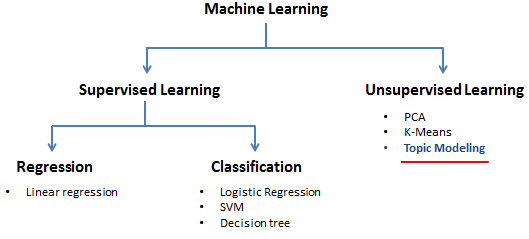

Source: https://thinkinfi.com/latent-dirichlet-allocation-for-beginners-a-high-level-overview/

# LDA(Latent Dirichlet Allocation)

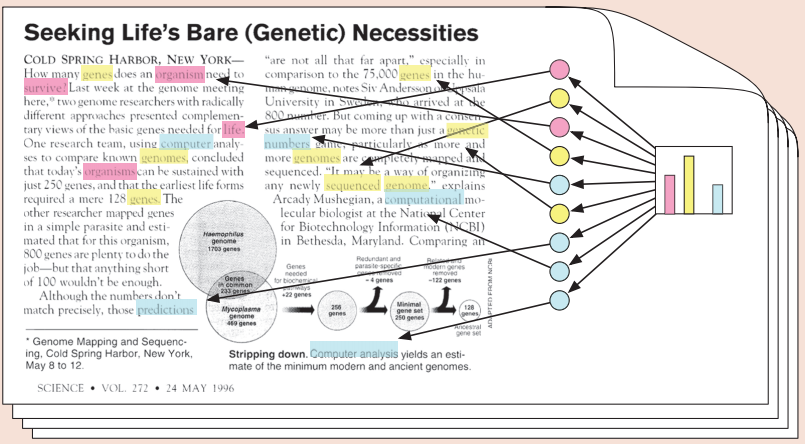

Blei, D. (2012), “Probabilistic Topic Models,” Communications of the ACM, 55, 77–84.

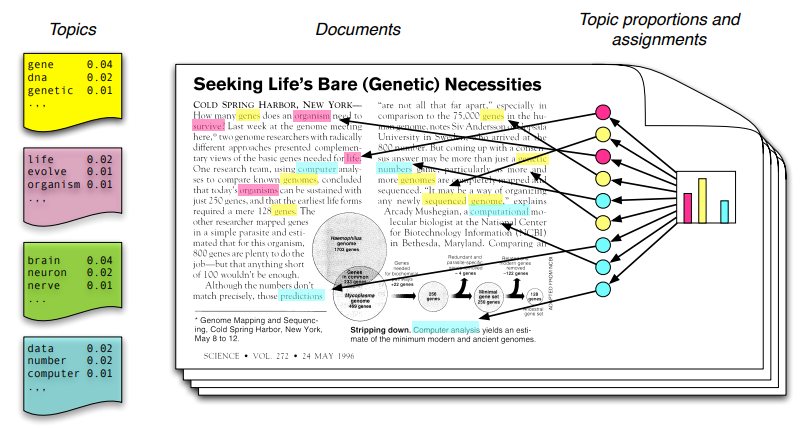

References

- D. Blei, A. Ng, and M. Jordan. (2013),  "Latent Dirichlet allocation," Journal of Machine Learning Research, 3:993–1022.
- https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05

https://github.com/JDataScience/topic-modeling

# Environment settings

In [ ]:
import os
print(os.getcwd())

In [ ]:
pip install -r requirements.txt --user

- conda install git

In [ ]:
# https://github.com/haven-jeon/PyKoSpacing
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git --user

In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git --user

## Restart!

In [ ]:
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore')
import re
from tqdm.notebook import tqdm
from IPython.core.display import HTML
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pickle
import numpy
import os
# Import mallet packages
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim import corpora
from gensim.models import CoherenceModel
from pprint import pprint

# 1. Data preparation and EDA

- Steam game review

In [ ]:
Greview = pd.read_csv("TotalGameReview.csv", encoding = "utf-8")

In [ ]:
Greview

In [ ]:
Counter(Greview['Gname'])

In [ ]:
Greview = Greview[['Rtext']]

In [ ]:
Greview.head()

In [ ]:
Greview.info()

In [ ]:
Greview.isnull().sum()

In [ ]:
Greview = Greview.dropna().reset_index(drop = True)

In [ ]:
Greview.isnull().sum()

# 2. Basic Preprocessing

In [ ]:
for i in Greview['Rtext'][0:50]:
    print(i); print("-"*30)

In [ ]:
def clean_text(text):
    '''
    Only Korean, English, and numbers are left.
    '''
    text = text.replace(".", " ").rstrip()
    text = re.sub(r'(https?://[^\s]+)', ' ', text)
    text = re.sub('[^가-힣|0-9|a-zA-Z]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text

In [ ]:
Greview['cleaned_text'] = ""
for i in tqdm(range(len(Greview))):
    Greview['cleaned_text'][i] = clean_text(Greview['Rtext'][i])

In [ ]:
%%time 
Greview['cleaned_text'] = Greview['Rtext'].apply(lambda x: clean_text(x))

In [ ]:
Greview = Greview[(Greview['cleaned_text']!= "") & (Greview['cleaned_text']!= " ")]
Greview = Greview.reset_index(drop = True)

In [ ]:
Greview

https://github.com/haven-jeon/PyKoSpacing

- PyKoSpacing

In [ ]:
from pykospacing import Spacing
spacing = Spacing()

In [ ]:
print(Greview['cleaned_text'][830])

In [ ]:
print(spacing(Greview['cleaned_text'][830]))

- py-hanspell

https://github.com/ssut/py-hanspell

In [ ]:
from hanspell import spell_checker

In [ ]:
spelled_sent = spell_checker.check(Greview['cleaned_text'][830])

In [ ]:
print(Greview['cleaned_text'][830])

In [ ]:
print(spelled_sent.checked)

In [ ]:
def spell_check(text):
    try:
        spelled_sent = spell_checker.check(text)
        text = spelled_sent.checked
    except:
        text = text
    return text

In [ ]:
%%time
Greview['spell_check'] = Greview['cleaned_text'].apply(lambda x: spell_check(x))

In [ ]:
Greview = pd.read_csv("temp.csv", encoding = "utf-8")

In [ ]:
temp = Greview[['Rtext', 'spell_check']].sample(n = 5, random_state = 20).reset_index(drop=True)
temp.columns = ['변경 전', '변경 후']
display(HTML(temp.to_html()))

In [ ]:
Greview.isnull().sum()

In [ ]:
Greview['spell_check'][0]

In [ ]:
for i in tqdm(range(len(Greview))):
    if type(Greview['spell_check'][i]) == float:
        Greview['spell_check'][i] = Greview['cleaned_text'][i]

In [ ]:
Greview.isnull().sum()

# 3. Tokenization

In [ ]:
import platform
print(platform.architecture())

https://github.com/lovit/customized_konlpy

- 참고: https://thinking-developer.tistory.com/45

In [ ]:
# https://www.oracle.com/java/technologies/javase-downloads.html
# 경로설정 = C:\Program Files\Java\jdk-16.0.2

In [ ]:
# twitter 형태소 분석기
from ckonlpy.tag import Twitter

In [ ]:
twitter = Twitter()

In [ ]:
print(Greview['spell_check'][0])
print(twitter.pos(Greview['spell_check'][0]))

In [ ]:
print(Greview['spell_check'][6])
print(twitter.pos(Greview['spell_check'][6]))

In [ ]:
twitter.add_dictionary('1회차', 'Noun')

In [ ]:
print(Greview['spell_check'][6])
print(twitter.pos(Greview['spell_check'][6]))

In [ ]:
# For English
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [ ]:
stop_words = []

In [ ]:
from ckonlpy.tag import Postprocessor

In [ ]:
# 명사만
passtags = {'Noun'}
postprocessor = Postprocessor(twitter, passtags = passtags)
postprocessor.pos(Greview['spell_check'][6])

In [ ]:
def tokenization(text):
    tokens = postprocessor.pos(text)
    tokens = [word[0] for word in tokens if word[0] not in stop_words]
    return tokens

In [ ]:
%%time
Greview['tokens'] = Greview['spell_check'].apply(lambda x: tokenization(x))

In [ ]:
Greview['token_len'] = Greview['tokens'].apply(lambda x: len(x))

In [ ]:
Greview = Greview[Greview['token_len']>=3]

In [ ]:
Greview[92:93]

In [ ]:
import ast
Greview['tokens'] = Greview['tokens'].apply(lambda x: ast.literal_eval(x))

In [ ]:
Greview['tokens'][0]

# Additional preprocessing

In [ ]:
# Join the review.
word_list = ",".join([",".join(i) for i in Greview['tokens']])
word_list = word_list.split(",")

In [ ]:
word_count = pd.Series(word_list).value_counts()

In [ ]:
# Create a WordCloud object - 한글은 폰트 경로 설정 꼭 해주어야 함
wordcloud = WordCloud(font_path = "‪‪C:/Windows\/Fonts/HMFMMUEX.TTC",
                      background_color="white", max_words=100, contour_width=3, contour_color='steelblue')

In [ ]:
# Generate a word cloud
wordcloud.generate_from_frequencies(dict(word_count))
plt.figure(figsize= (20,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Common 100 words in game reviews", pad = 14, weight = 'bold')
plt.show()

In [ ]:
word_count[0:50]

## Removing (in)frequent words /  Word transformation

In [ ]:
temp = pd.DataFrame(word_count, columns = ['count'])

In [ ]:
stop_words = list(temp[temp['count']==1].reset_index(drop = False)['index'])

In [ ]:
stop_words[0:10]

In [ ]:
stop_words.extend(["게임", "이", "것", "수", "안", "때", "그", "까지", "면서", "게", "거", "더", "좀", "내", "고", "적","면서", "해도", "길", "처럼", "생", "거의", "어가", "사람", 
                   "세", "함","말","임", "밀", "역", "번", "다가", "나", "어서", "걸", "중", "분", "탁", "려고", "지금", "어요", "개", "빻빻빻빻빻빻빻빻", "수도", "기", "하니",
                   "때문", "거나", "등","몬헌", "세키로", "위", "여", "리듬", "닥터", "스컬", "일", "듯", "지겐", "뭐", "부터", "건", "저", "보", "몬스터", "헌터", "주", "리", "제발", "진짜", "를",
                  "데", "면", "만큼", "제", "의", "게롤트", "시리", "트리스", "블러드", "두", "아하", "전", "로", "줄", "몇", "티", "해", "왜", "로", "꼭", "못", "모두", "인적", "하나", "남작", "피", "경우", "또한", "살", "이제",
                  "편", "정도", "와인", "또", "알", "보고", "그냥", "아직", "점", "스카이림", "가지", "일단", "즐", "이나", "시", "존나", "요", "사서", "예", "오브", "궨트", "난", "게로", "로트", "궨", "터", "후", "성", "도"])

In [ ]:
def word_change(word):
    if word == "겜":
        return "게임"
    if word == "잼":
        return "재미"
    if word == "퀘":
        return "퀘스트"
    return word

def add_pre(tokens):
    tokens = [word_change(word) for word in tokens if word not in stop_words]
    return tokens

In [ ]:
%%time
Greview['cleaned_tokens'] = Greview['tokens'].apply(lambda x: add_pre(x))

In [ ]:
Greview.to_csv("temp2.csv", encoding = "utf-8", index= False)

In [ ]:
Greview = pd.read_csv("temp2.csv", encoding = "utf-8")

In [ ]:
import ast
Greview['cleaned_tokens'] = Greview['cleaned_tokens'].apply(lambda x: ast.literal_eval(x))

# Bi-gram

In [ ]:
from nltk.util import everygrams

In [ ]:
Greview['cleaned_tokens'][21]

In [ ]:
list(everygrams(Greview['cleaned_tokens'][21], min_len =2, max_len = 2))

In [ ]:
%%time
Greview['bi_gram'] = Greview['cleaned_tokens'].apply(lambda x: ["_".join(i) for i in list(everygrams(x, min_len =1, max_len = 2))])

In [ ]:
Greview['bi_gram'][21]

# LDA MALLET

- http://mallet.cs.umass.edu/download.php

In [ ]:
os.environ['MALLET_HOME'] = 'C:/Mallet/' # My mallet path, it is needed to instantiate MAllet model

In [ ]:
#  point the path to the mallet path on my computer
mallet_path = 'c:/Mallet/bin/mallet' #insert the path

In [ ]:
texts = Greview['bi_gram']

In [ ]:
%%time
# Create Dictionary
id2word_1 = corpora.Dictionary(texts)

In [ ]:
print(id2word_1)

In [ ]:
id2word_1[0]

In [ ]:
%%time
# Create Corpus: Term Document Frequency
corpus_1 = [id2word_1.doc2bow(token) for token in texts]

In [ ]:
corpus_1[0:3]

In [ ]:
id2word_1[8]

In [ ]:
print(Greview['cleaned_tokens'][2])
print(Greview['cleaned_tokens'][2].count('보드'))

In [ ]:
%%time 
# Instantiate
ldamallet = LdaMallet(mallet_path, corpus=corpus_1, num_topics=10, id2word=id2word_1)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Optimum number of topics

1. perplexity
2. coherence score

In [ ]:
# Defining a function to get coherence score
def coherence_score(limit, start, step):
    coherence_values = []; model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus_1, num_topics=num_topics, id2word=id2word_1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word_1, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
%%time
# To get the coherence values
model_list, coherence_values = coherence_score(limit=11, start=3, step=1)

In [ ]:
# Show graph for the coherence value scores vs number of topics
limit=11; start=3; step=1;
topics = range(start, limit, step)
plt.plot(topics, coherence_values)
plt.title("Coherence value score with the number of topics")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [ ]:
# Print the coherence scores
for best, cv in zip(topics, coherence_values):
    print("Topic ", best, " has Coherence Value of", round(cv, 4))

In [ ]:
# printing the best topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

# 토픽 결과

#### 게임 자체에 대한 긍정 평가

- Topic 1: 게임 / 최고 / 갓 / 명작 / 필요 / 인생 / 할인 / 취향 / 인생게임 / 판타지

#### 게임 진행흐름에 대한 평가

- Topic 2: 재미 / 엔딩 / 처음 / 다시/ 초반 / 시작 / 지루 / 조금 / 드라마 / 인지

#### 플레이 경험에 기반한 평가

- Topic 3 : 스토리 / 전투 / 감/ 조작/ 단점 / 조작_감 / 진행 / 장점 / 액션 / 불편
- Topic 6 : 스토리 / 그래픽 / 모드 / 캐릭터 / 모든 / 매우 / 매력 /자체 / 완벽 / 작품
- Topic 7 : 시간 / 플레이 / 스토리 / 정말 / 추천 / 몰입 / 구매 / 스팀 / 영화 / 타임

#### 개인 견해에 기반한 평가

- Topic 4: 생각 / 선택 / 느낌 / 평가 / 다른 / 부분 / 주인공 / 세계관 / 시리즈 / 전작

#### 게임 내 퀘스트에 대한 평가

- Topic 5: 퀘스트 / 메인 /서브 / 서브_퀘스트 / 버그 / 메인_퀘스트 / 이야기 /메인_스토리 / 클리어 / 부가

In [ ]:
best_model = model_list[4]

In [ ]:
# Save model
with open('best.model', 'wb') as f:
    pickle.dump(mgp, f)
    f.close()

In [ ]:
# load in trained model 
filehandler = open('best.model', 'rb')
mgp = pickle.load(filehandler)

In [ ]:
pprint(mgp.print_topics(num_words=10))